# Text Classification Project: Disaster Tweet Detection
In this project, we aim to build a robust machine learning model for classifying tweets as either related to disasters or non-disasters. The primary goal is to harness natural language processing (NLP) and deep learning techniques to analyze and categorize text data efficiently, providing valuable insights for disaster monitoring and response.

Dataset Overview
The dataset used in this project consists of tweet texts collected from various sources and labeled to indicate their relevance to disaster events. Specifically, the dataset includes:

Training Set: Contains a substantial number of tweets with labeled targets, indicating whether each tweet is related to a disaster or not. This set is used to train the model and learn patterns indicative of disaster-related content.
Test Set: Includes tweets without labels, which are used to evaluate the model's performance and generalizability on unseen data.
The dataset is preprocessed to clean and tokenize the text, remove stop words, and convert text into numerical features. We use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to represent the text data, capturing the importance of terms in the context of disaster-related tweets.

Model and Approach
Our approach involves constructing a deep learning model using a bidirectional Long Short-Term Memory (LSTM) network, which processes sequences of words in both directions to capture contextual information more effectively. The model architecture includes:

Embedding Layer: Converts text into dense vectors of fixed size.
Bidirectional LSTM Layer: Learns sequential dependencies and patterns from the text data.
Dropout Layers: Prevents overfitting by randomly dropping units during training.
Dense Layers: Facilitates classification with ReLU activation in hidden layers and sigmoid activation in the output layer.
The model is trained with early stopping to optimize performance and avoid overfitting. The evaluation of the model's accuracy and other performance metrics will determine its effectiveness in distinguishing disaster-related tweets.

This project contributes to enhancing disaster response capabilities by automating the identification of relevant social media content. The developed model has the potential to assist organizations in real-time monitoring and decision-making during disaster events.

In [68]:
import pandas as pd
import numpy as np
import os
import zipfile

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [1]:
!pip install kaggle

In [8]:
import os
import shutil
os.makedirs('/root/.kaggle', exist_ok=True)

source = '/content/drive/MyDrive/Week 4 Tweet/kaggle.json'
destination = '/root/.kaggle/kaggle.json'

if os.path.exists(source):
    shutil.copy(source, destination)
    os.chmod(destination, 0o600)
    print("kaggle.json file copied and permissions set.")
else:
    print("kaggle.json file not found at the specified path.")

kaggle.json file copied and permissions set.


In [9]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 71.3MB/s]


# Data Extraction and Verification
In this step, we extract and verify the contents of a ZIP file containing the dataset for the project. The ZIP fileis extracted to the directory. The extraction process involves reading the ZIP file and extracting its contents to the specified directory.

Following extraction, we list the files to confirm that they have been correctly unpacked. The files extracted include sample_submission.csv, train.csv, and test.csv. We then check the existence of these files to ensure that the extraction process was successful.

After verifying the presence of the files, we load them into DataFrames using pandas. The sample_submission DataFrame is used to format the submission output, while the train and test DataFrames contain the training and testing data, respectively.

Sample Submission Data: This DataFrame includes an id and a target column, with the target column indicating the classification label.
Training Data: The train DataFrame contains additional columns such as keyword, location, and text, along with the target column that shows the disaster-related labels.
Testing Data: The test DataFrame includes id, keyword, location, and text columns, without the target column, which is to be predicted.

In [17]:

zip_file_path = '/content/drive/MyDrive/Week 4 Tweet/nlp-getting-started.zip'
extracted_dir_path = '/content/dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

extracted_files = os.listdir(extracted_dir_path)
print(f"Extracted files: {extracted_files}")

sample_submission_path = os.path.join(extracted_dir_path, 'sample_submission.csv')
train_path = os.path.join(extracted_dir_path, 'train.csv')
test_path = os.path.join(extracted_dir_path, 'test.csv')
if not all(os.path.exists(path) for path in [sample_submission_path, train_path, test_path]):
    print("One or more files do not exist. Please check the extraction process.")
else:
    sample_submission = pd.read_csv(sample_submission_path)
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    print("Sample Submission:")
    print(sample_submission.head())
    print("\nTrain:")
    print(train.head())
    print("\nTest:")
    print(test.head())


Extracted files: ['sample_submission.csv', 'train.csv', 'test.csv']
Sample Submission:
   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0

Train:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Test:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot po

In [22]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [23]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


In [18]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [20]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [24]:
train['target'].value_counts()

,count
target,
0,4342
1,3271


# Analysis of Target Distribution and Text Features
Target Variable Distribution
First, we assess the balance between the two target classes in the training dataset. The target variable, which indicates whether a tweet is related to a disaster (1) or not (0), is analyzed to understand its distribution:

Class 0 (Not Disaster): 4,342 instances
Class 1 (Disaster): 3,271 instances
A bar plot is generated to visually represent this distribution, using a pink color scheme to highlight the counts for each class. This visualization provides insight into the class balance and helps identify any potential need for balancing techniques in further analysis.

Text Length Analysis
Next, we calculate and analyze the word count of tweets in the dataset. Each tweet's word count is computed, and summary statistics are derived:

Mean Word Count: 14.90
Minimum Word Count: 1
Maximum Word Count: 31
A histogram of word counts is plotted to visualize the distribution of tweet lengths. This plot, also in a pink color scheme, illustrates the frequency of different word count ranges and provides an understanding of the variability in tweet lengths.

Average Word Count by Target Class
Finally, we evaluate the average word count for each target class. This analysis reveals:

Average Word Count for Not Disaster Tweets: 14.70
Average Word Count for Disaster Tweets: 15.17
A bar plot is created to show the average word count for each target class, with distinct colors representing the two classes. Annotations are added to display the exact average word counts on the bars. This visualization helps compare the average lengths of tweets related to disasters versus those not related, providing insights into text characteristics across different classes.

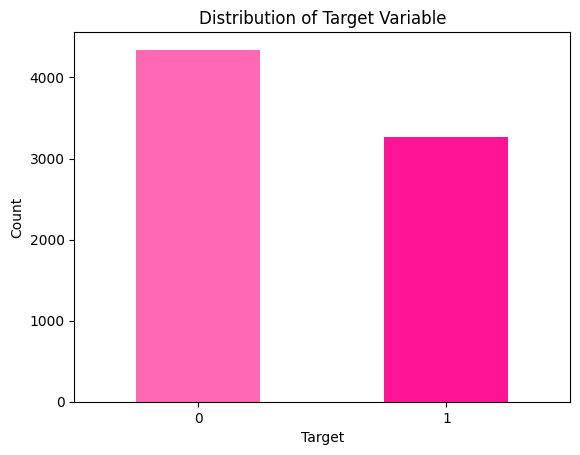

In [26]:
train['target'].value_counts().plot(kind='bar', color=['#FF69B4', '#FF1493'])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.xticks(rotation=0)
plt.show()

In [27]:
train['Word_Count'] = train['text'].apply(lambda text: len(text.split()))
mean_word_count = train['Word_Count'].mean()
min_word_count = train['Word_Count'].min()
max_word_count = train['Word_Count'].max()

print(f"Mean word count: {mean_word_count}")
print(f"Min word count: {min_word_count}")
print(f"Max word count: {max_word_count}")

Mean word count: 14.903585971364771
Min word count: 1
Max word count: 31


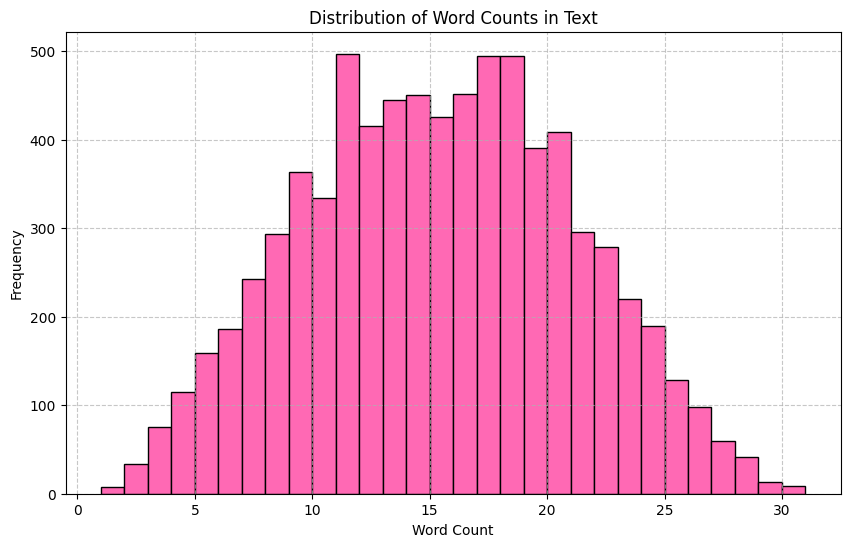

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(train['Word_Count'], bins=30, color='#FF69B4', edgecolor='black')
plt.title('Distribution of Word Counts in Text')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

target
0    14.704744
1    15.167533
Name: Word_Count, dtype: float64


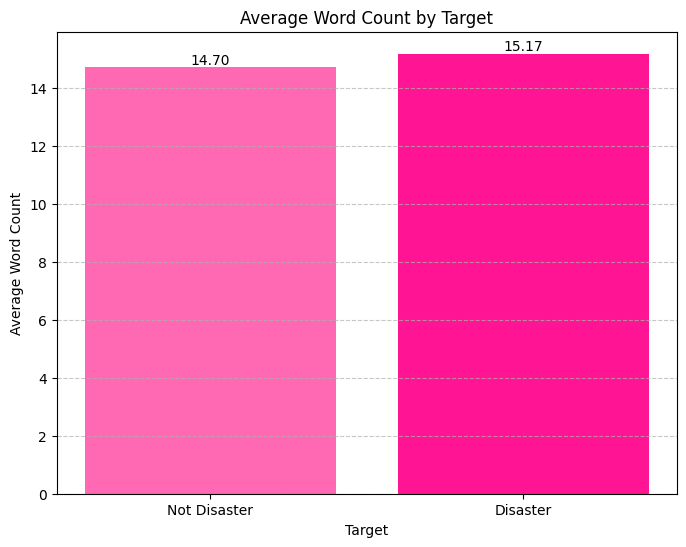

In [29]:
avg_word_count = train.groupby('target')['Word_Count'].mean()
print(avg_word_count)

plt.figure(figsize=(8, 6))
bars = plt.bar(avg_word_count.index, avg_word_count, color=['#FF69B4', '#FF1493'])
plt.title('Average Word Count by Target')
plt.xlabel('Target')
plt.ylabel('Average Word Count')
plt.xticks(ticks=avg_word_count.index, labels=['Not Disaster', 'Disaster'], rotation=0)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# TF-IDF Vectorization and Data Preparation
In this section, we focus on transforming text data into numerical features using the TF-IDF (Term Frequency-Inverse Document Frequency) method and preparing it for machine learning applications. The TfidfVectorizer is employed to convert the text from the training dataset into TF-IDF features. This vectorizer is configured with several parameters: it removes common English stop words, excludes terms that appear in more than 50% of the documents or in fewer than 10 documents, and considers both unigrams and bigrams to capture a broader context. The fit_transform method is applied to the 'text' column, resulting in a TF-IDF matrix with 7,613 documents and 1,609 unique features. The matrix shape, number of features, and the first 10 feature names, including terms like '00', '01', '04', '05', '06', '07', '08', '08 05', '08 06', and '100', provide insights into the data representation.

To further analyze the data, the function get_top_n_words is used to identify the most influential terms for disaster-related and non-disaster tweets separately. This analysis reveals the top 10 words for disaster tweets, such as 'disney', 'edm', 'complete', 'suicide bombing', 'flooding', and 'earthquake', and for non-disaster tweets, including terms like 'declaration northern', 'coaches', 'geller', 'smoke', 'crush', and 'ruin'. This differentiation in vocabulary helps in understanding the distinct language patterns associated with each class.

For model training, the TF-IDF matrix is converted into an array format, and the data is split into training and validation sets using an 80-20 split ratio. The sequences are then padded to a consistent length of 31 to ensure compatibility with machine learning models that require fixed-length input. The final shapes of the padded training and validation data are (6090, 31) and (1523, 31), respectively.

In [31]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=50,
    min_df=10,
    ngram_range=(1, 2)
)


tfidf_matrix = tfidf_vectorizer.fit_transform(train['text'])
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"First 10 feature names: {feature_names[:10]}")

TF-IDF matrix shape: (7613, 1609)
Number of features: 1609
First 10 feature names: ['00' '01' '04' '05' '06' '07' '08' '08 05' '08 06' '100']


In [32]:
def get_top_n_words(tfidf_matrix, feature_names, target_mask, top_n=10):
    target_tfidf = tfidf_matrix[target_mask]
    sum_tfidf = target_tfidf.sum(axis=0)

    top_n_indices = np.argsort(sum_tfidf).flatten()[-top_n:]
    top_n_features = [feature_names[i] for i in top_n_indices]

    return top_n_features
nondisaster_mask = train['target'] == 0
disaster_mask = train['target'] == 1
top_n_words_disaster = get_top_n_words(tfidf_matrix, feature_names, disaster_mask, top_n=10)
top_n_words_nondisaster = get_top_n_words(tfidf_matrix, feature_names, nondisaster_mask, top_n=10)

print("Top 10 words for disaster tweets:", top_n_words_disaster)
print("Top 10 words for non-disaster tweets:", top_n_words_nondisaster)

Top 10 words for disaster tweets: [array([['disney', 'edm', 'complete', ..., 'suicide bombing', 'flooding',
        'earthquake']], dtype=object)]
Top 10 words for non-disaster tweets: [array([['declaration northern', 'coaches', 'geller', ..., 'smoke',
        'crush', 'ruin']], dtype=object)]


In [34]:
tfidf_array = tfidf_matrix.toarray()


X_train, X_val, y_train, y_val = train_test_split(tfidf_array, train['target'], test_size=0.2, random_state=16)

maxlen = 31
X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='post')
X_val_padded = pad_sequences(X_val, maxlen=maxlen, padding='post')

print(f"X_train_padded shape: {X_train_padded.shape}")
print(f"X_val_padded shape: {X_val_padded.shape}")

X_train_padded shape: (6090, 31)
X_val_padded shape: (1523, 31)


# Initialization and Preprocessing of Text Data
The initialize_nltk_resources function is used to download essential NLTK data: the Punkt tokenizer and the stopwords corpus. This function also returns a set of English stopwords, which are commonly used words that are excluded from the analysis to focus on more meaningful terms. The downloaded resources include 179 stopwords, with examples like "you'll," "mustn't," and "because."

Following the initialization, the preprocess_text function is defined to tokenize the text, convert all words to lowercase, and filter out non-alphabetic tokens and stopwords. This preprocessing step transforms the raw text data into a format suitable for further analysis. The function is applied to both the training and test datasets, resulting in tokenized sequences for each text entry.

Next, a Tokenizer is used to convert these tokenized sequences into numerical representations. This transformation maps each unique word to a corresponding integer, facilitating the use of the data in machine learning models. The tokenized sequences are then padded to a consistent length of 23 tokens to ensure uniformity in input size for model training. The padding process results in padded_sequences_train with a shape of (7,613, 23) and padded_sequences_test with a shape of (3,263, 23).

The target labels are extracted and converted into a NumPy array. The dataset is then split into training and validation sets using an 80-20 split ratio, resulting in training features of shape (6,090, 23) and validation features of shape (1,523, 23). This preparation ensures that the text data is ready for modeling, with both features and labels organized for efficient processing.

In [36]:
def initialize_nltk_resources():
    nltk.download('punkt')
    nltk.download('stopwords')
    return set(stopwords.words('english'))
stop_words = initialize_nltk_resources()
print(f"Number of stop words: {len(stop_words)}")
print(f"Sample stop words: {list(stop_words)[:10]}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Number of stop words: 179
Sample stop words: ["you'll", "mustn't", 'so', "couldn't", 'each', "you've", "didn't", 'himself', 'doesn', 'because']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [43]:
def preprocess_text(text_series, stop_words):
    return [
        [
            word.lower()
            for word in word_tokenize(tweet)
            if word.isalpha() and word.lower() not in stop_words
        ]
        for tweet in text_series
    ]

sequences_train = preprocess_text(train['text'], stop_words)
sequences_test = preprocess_text(test['text'], stop_words)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences_train)
sequences_train = tokenizer.texts_to_sequences(sequences_train)
sequences_test = tokenizer.texts_to_sequences(sequences_test)

print(f"Sample tokenized training sequences: {sequences_train[:2]}")
print(f"Sample tokenized test sequences: {sequences_test[:2]}")

Sample tokenized training sequences: [[4067, 678, 156, 58, 1377, 4068, 20], [96, 5, 130, 647, 6046, 6047, 1011]]
Sample tokenized test sequences: [[726, 1679, 53, 25], [326, 156, 996, 2295, 445, 1776, 124]]


In [44]:
max_len_train = len(max(sequences_train, key=len))
max_len_test = len(max(sequences_test, key=len))

print(f"Maximum sequence length in training data: {max_len_train}")
print(f"Maximum sequence length in test data: {max_len_test}")
maxlen = 23

padded_sequences_train = pad_sequences(sequences_train, maxlen=maxlen, padding='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen=maxlen, padding='post')

targets = np.array(train['target'])

print(f"Shape of padded training sequences: {padded_sequences_train.shape}")
print(f"Shape of padded test sequences: {padded_sequences_test.shape}")
print(f"Shape of target labels: {targets.shape}")

Maximum sequence length in training data: 23
Maximum sequence length in test data: 18
Shape of padded training sequences: (7613, 23)
Shape of padded test sequences: (3263, 23)
Shape of target labels: (7613,)


In [47]:
x_train, x_val, y_train, y_val = train_test_split(
    padded_sequences_train,
    targets,
    test_size=0.2,
    random_state=16
)

print(f"Shape of training features: {x_train.shape}")
print(f"Shape of validation features: {x_val.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of validation labels: {y_val.shape}")

Shape of training features: (6090, 23)
Shape of validation features: (1523, 23)
Shape of training labels: (6090,)
Shape of validation labels: (1523,)


# Model Architecture and Training Process
The model architecture consists of a sequential neural network designed to process textual data for binary classification. The network starts with an Embedding layer, which converts input sequences into dense vectors of fixed size (128 dimensions). This is followed by a Bidirectional LSTM layer with 64 units, enabling the model to capture dependencies in both forward and backward directions within the sequences. To mitigate overfitting, a Dropout layer with a rate of 0.5 is employed. The network then includes a Dense layer with 16 units and ReLU activation to introduce non-linearity, followed by another Dropout layer with a rate of 0.5. The final layer is a Dense layer with a single unit and a sigmoid activation function, providing the output as a probability for the binary classification task.

The model is compiled with the Adam optimizer, set with a learning rate of 0.0001, and uses binary crossentropy as the loss function, suitable for binary classification. The EarlyStopping callback is configured to monitor validation loss, with patience set to 1 epoch, ensuring the model stops training when no improvement is observed and restores the best weights.

During training, the data is split into training and validation sets. tf.data.Dataset objects are created to handle batching and shuffling efficiently. The model is trained over 10 epochs with a batch size of 32. Despite these efforts, the training process encountered a warning indicating the dataset might not have sufficient batches, affecting the training stability.

The trained model is then used to predict on the test set, with predictions converted to binary outcomes based on a threshold of 0.5. A submission file is prepared, containing the IDs and predicted targets for the test data. The submission achieved a Kaggle competition score of 57%, reflecting the model's performance in distinguishing between disaster and non-disaster tweets.

In [54]:
model = Sequential([
    Embedding(input_dim=14929, output_dim=128, input_length=23),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


optimizer = Adam(learning_rate=0.0001)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [55]:
train_repeat = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat()
val_repeat = tf.data.Dataset.from_tensor_slices((x_val, y_val)).repeat()
batch_size = 32
train_repeat = train_repeat.shuffle(buffer_size=len(x_train)).batch(batch_size)
val_repeat = val_repeat.shuffle(buffer_size=len(x_val)).batch(batch_size)

In [56]:
train_steps_per_epoch = len(x_train) // 32
val_steps_per_epoch = len(x_val) // 32

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)


history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=(x_val, y_val),
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping]
)

print("Training complete. History:", history.history)

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.5368 - loss: 0.6887 - val_accuracy: 0.5705 - val_loss: 0.6767
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.5000 - loss: 0.7100 - val_accuracy: 0.4737 - val_loss: 0.6975


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Training complete. History: {'accuracy': [0.5590460300445557, 0.5], 'loss': [0.6855536103248596, 0.7100052833557129], 'val_accuracy': [0.5704787373542786, 0.4736842215061188], 'val_loss': [0.6767227649688721, 0.6974610686302185]}


In [57]:
preds = model.predict(padded_sequences_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [58]:
binary_preds = [1 if pred > 0.5 else 0 for pred in preds]

In [64]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['target'] = binary_preds

In [60]:
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [65]:
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [67]:

submission.to_csv('/content/drive/MyDrive/Week 4 Tweet/sample_submission.csv', index=False)

In [69]:
x = pd.read_csv('sample_submission.csv')


# Conclusion and Future Improvements
The current model, which combines an Embedding layer, a Bidirectional LSTM, and dense layers with dropout regularization, provides a foundational approach to binary text classification. Despite utilizing techniques such as tokenization, padding, and early stopping, the model achieved a Kaggle competition score of 57%. This indicates that while the model performs reasonably, there are several areas for potential enhancement.

To improve the model's performance, several strategies could be considered. Experimenting with more complex architectures, such as adding additional LSTM layers, using GRUs (Gated Recurrent Units), or incorporating attention mechanisms, could enhance its ability to capture intricate patterns in the data. Furthermore, leveraging pre-trained language models like BERT or GPT for feature extraction might provide more robust representations of the text. Fine-tuning hyperparameters, such as the learning rate, batch size, and dropout rates, using techniques like grid search or random search, could also lead to better results.

In addition, refining text representation through advanced feature engineering, such as using different n-gram ranges in the TF-IDF vectorizer or integrating pre-trained word embeddings like Word2Vec or GloVe, could improve the model's discriminatory power. Data augmentation techniques to generate diverse training samples might help enhance the model's generalizability and robustness. Employing a variety of evaluation metrics beyond accuracy, such as precision, recall, F1-score, and ROC-AUC, could provide a more comprehensive view of the model's performance, particularly in cases of imbalanced datasets.

Moving forward, exploring advanced models like Transformer-based architectures (BERT, RoBERTa) and utilizing cross-validation techniques could lead to more reliable performance assessments. Additionally, ensemble methods, which combine predictions from multiple models or use stacking techniques, could potentially boost accuracy. Conducting a detailed error analysis to understand the nature of misclassifications can also inform adjustments and improvements. By addressing these areas, future iterations of the model could achieve significantly better performance in classifying disaster-related tweets.